### Introduction  

This notebook analyses passenger traffic at Los Angeles International Airport (LAX) by terminal, using three different models in the following order: XGBoost (XGB), K-Means Clustering, and Prophet. The objective is to understand traffic patterns, segment terminals based on passenger flow, and forecast future trends.  

Key areas covered:  
- XGBoost modelling: Predicting passenger traffic using a machine learning approach to identify key factors influencing traffic patterns.  
- Clustering analysis (K-Means): Grouping terminals based on passenger volume and variability to uncover operational patterns.  
- Time series forecasting (Prophet): Predicting passenger numbers for 2023-2024 and assessing forecast reliand MAPE.  

By combining machine learning, clustering, and time series forecasting, this analysis provides a comprehensive view of passenger traffic trends across LAX terminals and insights into future airport traffic behaviour.

In [1886]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [1887]:
LA = pd.read_csv(r'C:\Users\hp\Documents\Datasets\airport_passenger_data.csv')

## Exploratory Data Analysis

In [1889]:
LA.head()

,DataExtractDate,Terminal,Arrival_Departure,Domestic_International,Passenger_Count
0,01/01/2019 08:15:30 PM,TBIT,Arrival,International,27705
1,01/01/2019 11:25:00 PM,T5,Arrival,Domestic,19635
2,01/01/2019 03:34:50 AM,T2,Arrival,International,22498
3,01/01/2019 03:15:35 PM,T7,Arrival,International,18680
4,01/01/2019 05:26:02 AM,T4,Arrival,Domestic,20243


In [1890]:
LA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20086 entries, 0 to 20085
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DataExtractDate         20086 non-null  object
 1   Terminal                20086 non-null  object
 2   Arrival_Departure       20086 non-null  object
 3   Domestic_International  20086 non-null  object
 4   Passenger_Count         20086 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 784.7+ KB


In [1891]:
LA.duplicated().sum()

0

In [1892]:
LA.isna().sum()

DataExtractDate           0
Terminal                  0
Arrival_Departure         0
Domestic_International    0
Passenger_Count           0
dtype: int64

In [1893]:
# Feature engineering to exract feqtures
# Convert to datetime format
LA['DataExtractDate'] = pd.to_datetime(LA['DataExtractDate'], format='mixed')

# features
LA['Year'] = LA['DataExtractDate'].dt.year
LA['Month'] = LA['DataExtractDate'].dt.month
LA['Day'] = LA['DataExtractDate'].dt.day
LA['Weekday'] = LA['DataExtractDate'].dt.weekday  # Monday=0, Sunday=6
LA['Hour'] = LA['DataExtractDate'].dt.hour

LA.head()

,DataExtractDate,Terminal,Arrival_Departure,Domestic_International,Passenger_Count,Year,Month,Day,Weekday,Hour
0,2019-01-01 20:15:30,TBIT,Arrival,International,27705,2019,1,1,1,20
1,2019-01-01 23:25:00,T5,Arrival,Domestic,19635,2019,1,1,1,23
2,2019-01-01 03:34:50,T2,Arrival,International,22498,2019,1,1,1,3
3,2019-01-01 15:15:35,T7,Arrival,International,18680,2019,1,1,1,15
4,2019-01-01 05:26:02,T4,Arrival,Domestic,20243,2019,1,1,1,5


In [1894]:
LA = LA[LA['Year'] != 2018]
LA.head()

,DataExtractDate,Terminal,Arrival_Departure,Domestic_International,Passenger_Count,Year,Month,Day,Weekday,Hour
0,2019-01-01 20:15:30,TBIT,Arrival,International,27705,2019,1,1,1,20
1,2019-01-01 23:25:00,T5,Arrival,Domestic,19635,2019,1,1,1,23
2,2019-01-01 03:34:50,T2,Arrival,International,22498,2019,1,1,1,3
3,2019-01-01 15:15:35,T7,Arrival,International,18680,2019,1,1,1,15
4,2019-01-01 05:26:02,T4,Arrival,Domestic,20243,2019,1,1,1,5


# Numerical analysis

In [1896]:
LA['Passenger_Count'].describe()

count    20086.000000
mean     11784.039281
std       8141.450889
min        400.000000
25%       4737.250000
50%       9970.000000
75%      18017.750000
max      35998.000000
Name: Passenger_Count, dtype: float64

<Axes: xlabel='Passenger_Count', ylabel='Count'>

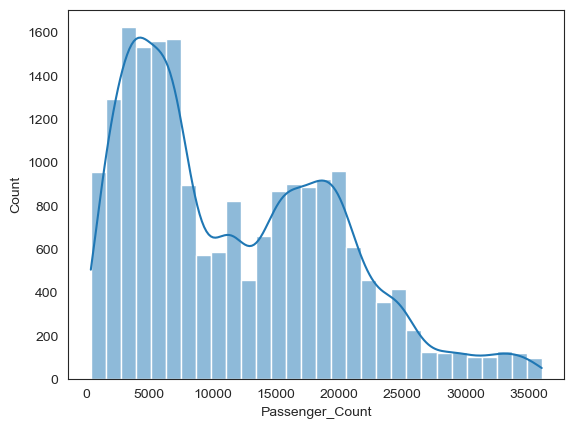

In [1897]:
# Passenger count distrubution
sns.histplot(LA['Passenger_Count'], bins=30, kde=True)

This histogram shows the distribution of passenger counts. It shows two main peaks in passenger numbers—one around 5,000 and another near 20,000. This suggests that most passenger counts tend to fall within these two ranges, with fewer cases in between. The chart also stretches more towards the higher end, meaning there are some instances where passenger numbers are much higher than usual.

Text(0.5, 1.0, 'Passenger Trend')

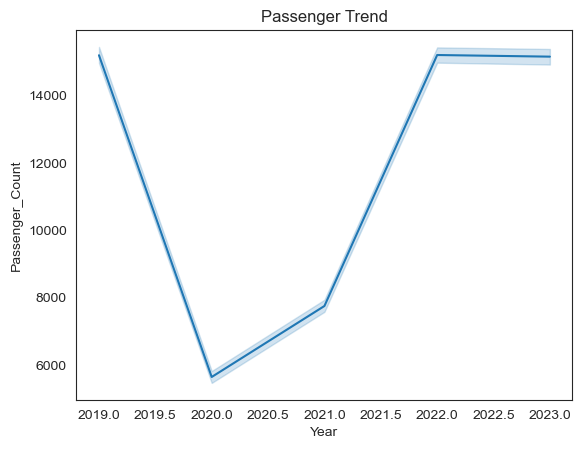

In [1899]:
# passenger trends over time
sns.lineplot(x=LA['Year'], y=LA['Passenger_Count'])
plt.title('Passenger Trend')

The most striking feature in this chart is the sharp drop in 2020, likely due to the COVID-19 pandemic, followed by a gradual recovery through 2023, returning to pre-pandemic levels. This trend highlights the pandemic's impact, the ongoing recovery process, and potential uncertainties for future travel patterns.

<Axes: xlabel='Passenger_Count'>

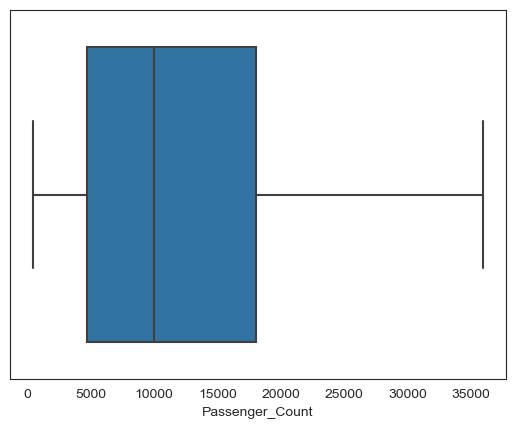

In [1901]:
sns.boxplot(x=LA['Passenger_Count'])

This boxplot shows the distribution of passenger counts. The median is closer to the left, showing a right-skewed distribution, meaning most passenger counts are low, but a few are much higher. The longer right whisker and outliers suggest high variability in larger counts. This confirms the pattern seen in the histogram and highlights key data trends.

<Axes: xlabel='Month'>

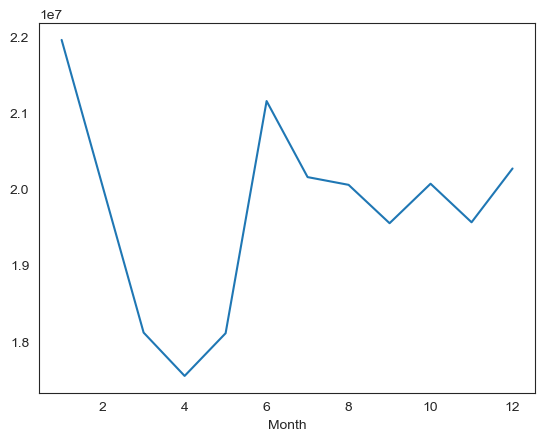

In [1903]:
monthly_passengers = LA.groupby('Month')['Passenger_Count'].sum()
sns.lineplot(x=monthly_passengers.index, y=monthly_passengers.values)

This line plot shows the change in passenger changes over 12 months. There’s a noticeable sharp drop from January to April, hitting the lowest point of the year. After that, numbers rise sharply until June. From June to December, passenger counts fluctuate but stay fairly steady. This pattern suggests a seasonal dip in early spring, followed by a rebound heading into summer.

Text(0.5, 1.0, 'International Passenger Trend')

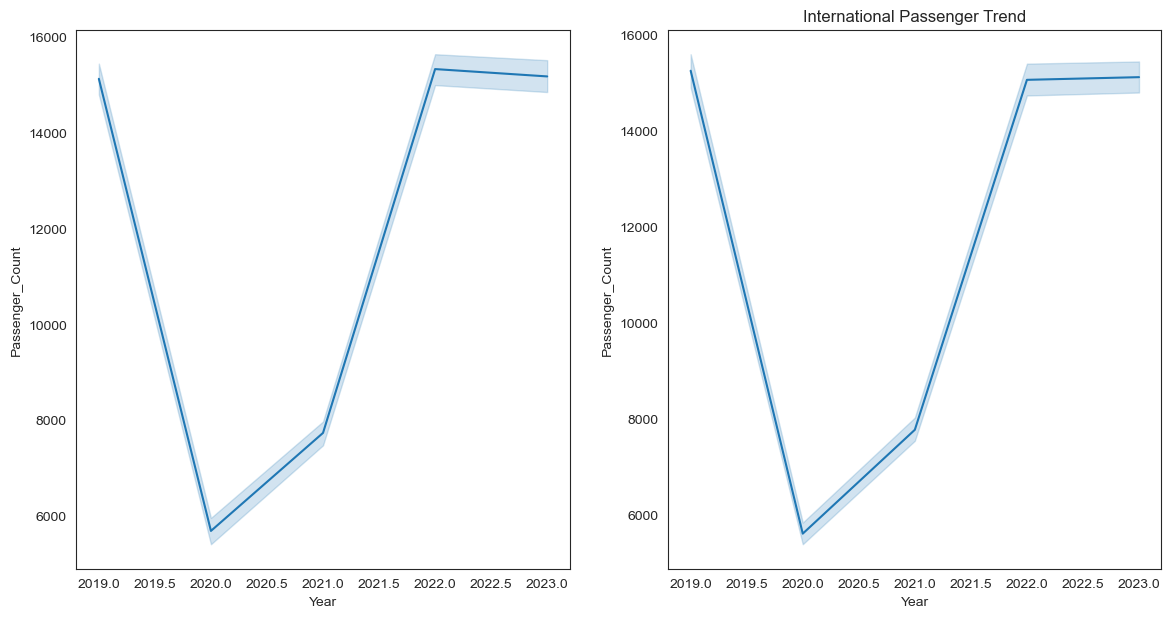

In [1905]:
# domestic and intl passenger trends
domestic = LA[LA['Domestic_International'] == 'Domestic'] # filtering domestic and international data from the dataframe
intl = LA[LA['Domestic_International'] == 'International']

fig, axis = plt.subplots(1, 2, figsize=(14,7))

sns.lineplot(x=domestic['Year'], y = domestic['Passenger_Count'], ax = axis [0])
plt.title('Domestic Passenger Trend')

sns.lineplot(x=intl['Year'], y = intl['Passenger_Count'], ax= axis[1])
plt.title('International Passenger Trend')

Both plots highlight a steep drop from 2019 to 2020, followed by a gradual recovery until 2021. There’s a sharp increase from 2021 to 2022, after which the numbers level off through 2023. The shaded area around the line indicates uncertainty in the data. Since both plots are the same, they don’t add new information but reinforce the overall trend.

Text(0.5, 1.0, 'Departure Passenger Trend')

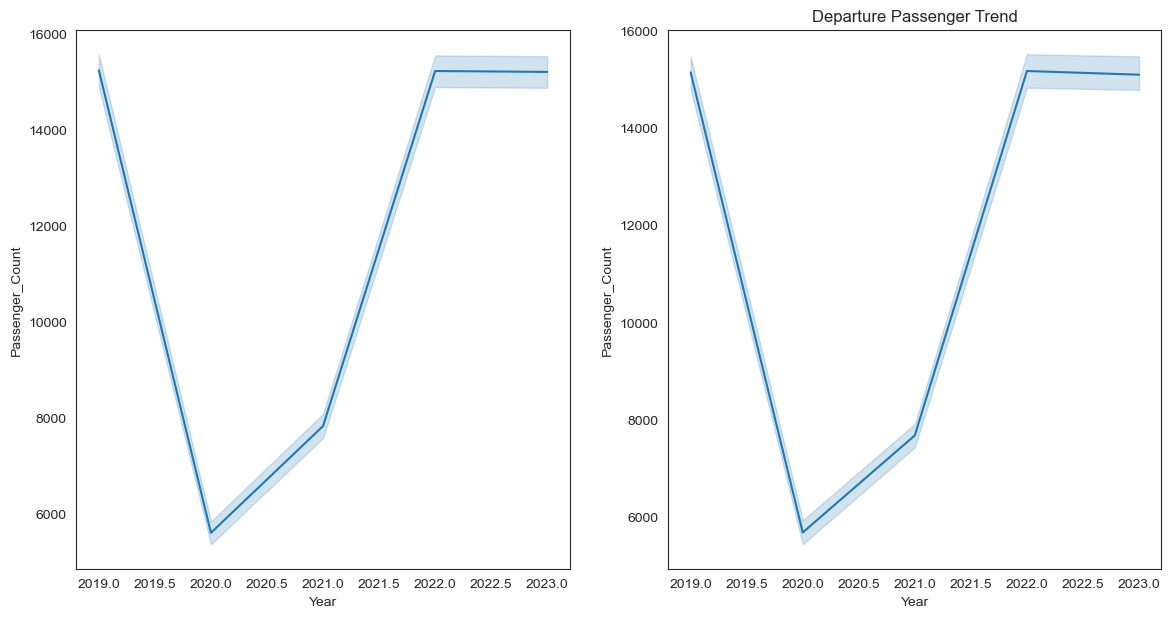

In [1907]:
# arrival and departure passenger trends
ari = LA[LA['Arrival_Departure'] == 'Arrival'] # filtering arivals and depatures data from the dataframe
dep = LA[LA['Arrival_Departure'] == 'Departure']

fig, axis = plt.subplots(1, 2, figsize=(14,7))

sns.lineplot(x=ari['Year'], y = ari['Passenger_Count'], ax = axis [0])
plt.title('Arrival Passenger Trend')

sns.lineplot(x=dep['Year'], y = dep['Passenger_Count'], ax= axis[1])
plt.title('Departure Passenger Trend')

Similar to domesstic and international travel trend, these charts show a steep decline from 2019 to 2020, followed by a gradual recovery in the following years.

In [1909]:
# Terminals
print('Number of terminals:', LA['Terminal'].nunique())
print('Terminal list:', LA['Terminal'].unique())

Number of terminals: 11
Terminal list: ['TBIT' 'T5' 'T2' 'T7' 'T4' 'T1' 'T6' 'T3' 'TBIT West Gates' 'T8'
 'Miscellaneous Terminal']


In [1910]:
# Busiest Terminal
LA.groupby('Terminal')['Passenger_Count'].sum().sort_values(ascending=False)

Terminal
TBIT                      42241143
T5                        30850579
T2                        29681641
T7                        26447968
T4                        24997029
T1                        23960107
T6                        19504437
T3                        14394191
TBIT West Gates            9956761
T8                         8997183
Miscellaneous Terminal     5663174
Name: Passenger_Count, dtype: int64

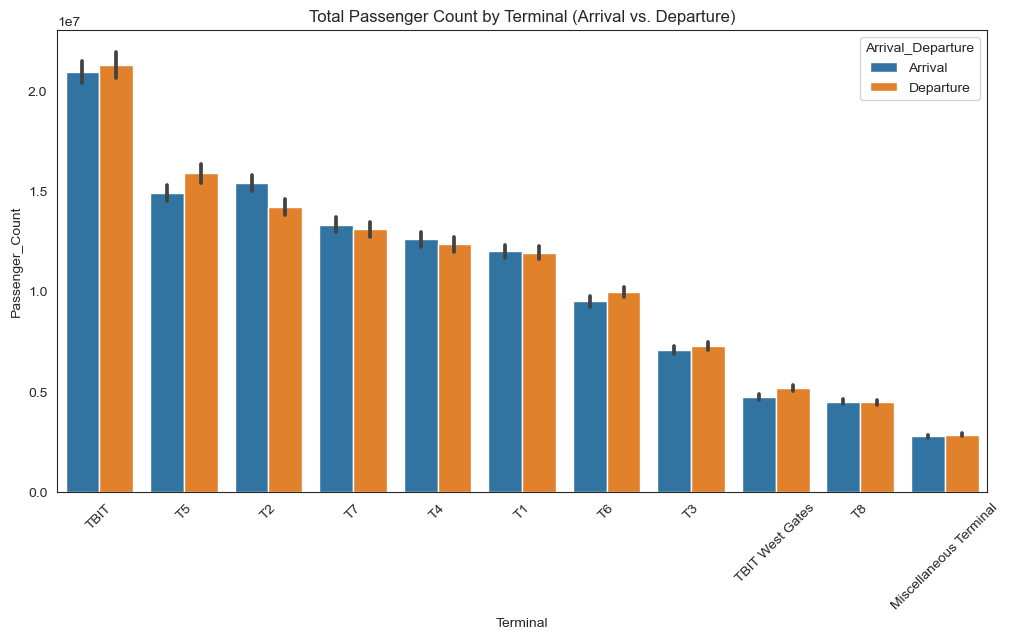

In [1911]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Terminal', y='Passenger_Count', hue='Arrival_Departure', data=LA, estimator=sum)
plt.xticks(rotation=45)
plt.title('Total Passenger Count by Terminal (Arrival vs. Departure)')
plt.show()

The table and chart show the total number of passengers handled by each terminal. TBIT sees the most traffic, handling 42 million passengers, followed by T5, T2, and T7, which also experience high volumes. Terminals like T8 and the Miscellaneous Terminal see fewer passengers, likely serving specific or lower-traffic flights.

In [1913]:
# Peak hours
print('Arrivals:')
arrival_trend = ari.groupby('Hour')['Passenger_Count'].sum().sort_values(ascending=False)
print(arrival_trend)
print('Departures:')
departure_trend = dep.groupby('Hour')['Passenger_Count'].sum().sort_values(ascending=False)
print(departure_trend)

Arrivals:
Hour
0     5383099
18    5357994
23    5245133
11    5214915
5     5138430
20    5115054
15    5111003
16    5104018
7     5062840
17    5036683
2     5005124
22    4980492
3     4943938
21    4941567
8     4936524
14    4810551
1     4767185
9     4712841
19    4688098
12    4643583
6     4539961
13    4514528
4     4453617
10    4221964
Name: Passenger_Count, dtype: int64
Departures:
Hour
5     5582156
3     5568402
17    5351944
14    5317268
1     5288410
18    5264155
0     5181385
2     5114991
6     5086209
20    5003090
13    4973812
10    4960560
23    4835771
4     4807551
15    4805723
7     4750996
21    4726418
11    4675659
22    4628460
12    4624060
8     4612931
16    4566874
9     4551199
19    4487047
Name: Passenger_Count, dtype: int64


<Axes: xlabel='Hour'>

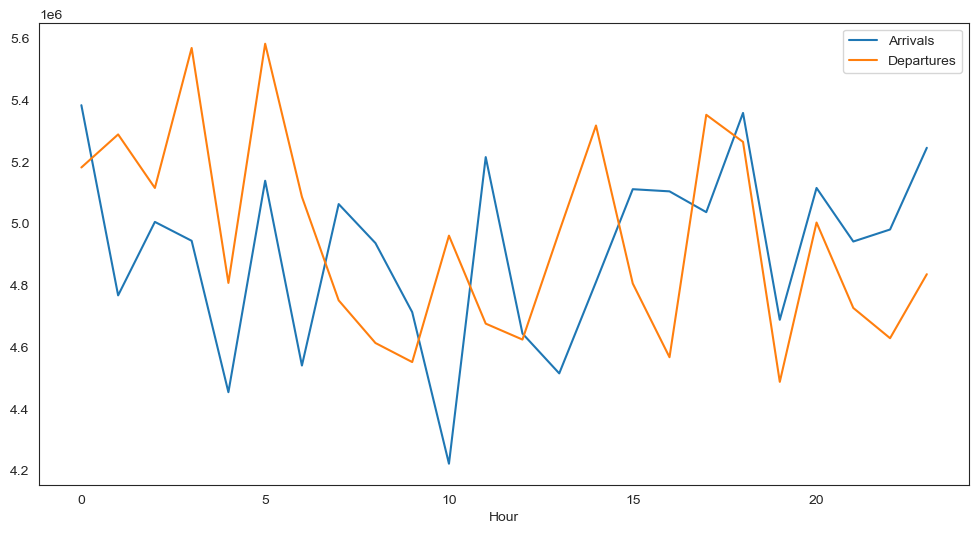

In [1914]:
# Plotting the trends
plt.figure(figsize=(12,6))
sns.lineplot(x=arrival_trend.index, y=arrival_trend.values, label='Arrivals')
sns.lineplot(x=departure_trend.index, y=departure_trend.values, label='Departures')

The data shows that arrivals and departures go up and down throughout the day, with several busy and quiet periods. There's no clear pattern where one is consistently higher than the other, meaning the timing of flights varies a lot.

In [1916]:
# Peak days
print('Arrivals:')
arrival_trend_day = ari.groupby('Weekday')['Passenger_Count'].sum().sort_values(ascending=False)
print(arrival_trend_day)
print('Departures:')
departure_trend_day = dep.groupby('Weekday')['Passenger_Count'].sum().sort_values(ascending=False)
print(departure_trend_day)

Arrivals:
Weekday
6    17330107
1    17303418
5    17067174
0    16930832
2    16756383
3    16487069
4    16054159
Name: Passenger_Count, dtype: int64
Departures:
Weekday
4    17840159
3    17394763
2    17113980
0    16838979
5    16775336
6    16407643
1    16394211
Name: Passenger_Count, dtype: int64


<Axes: xlabel='Weekday'>

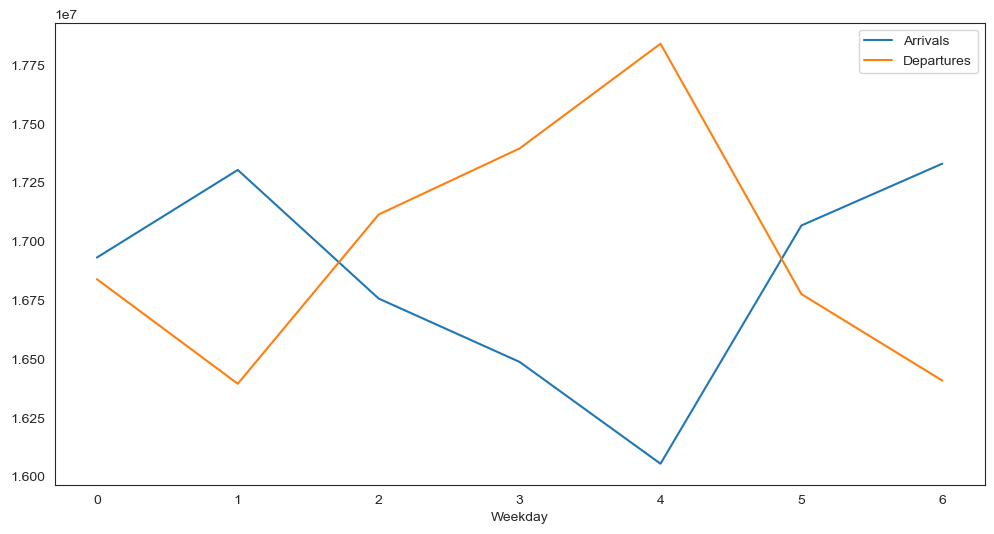

In [1917]:
# Plotting the trends
plt.figure(figsize=(12,6))
sns.lineplot(x=arrival_trend_day.index, y=arrival_trend_day.values, label='Arrivals')
sns.lineplot(x=departure_trend_day.index, y=departure_trend_day.values, label='Departures')

The data shows clear patterns for arrivals and departures throughout the week. Arrivals peak on Monday, then drop to their lowest on Thursday before gradually rising again by Saturday. Departures follow the opposite trend, starting low on Monday, increasing steadily to a peak on Thursday, and then declining towards Saturday. This suggests that arrivals and departures have different peak travel days.

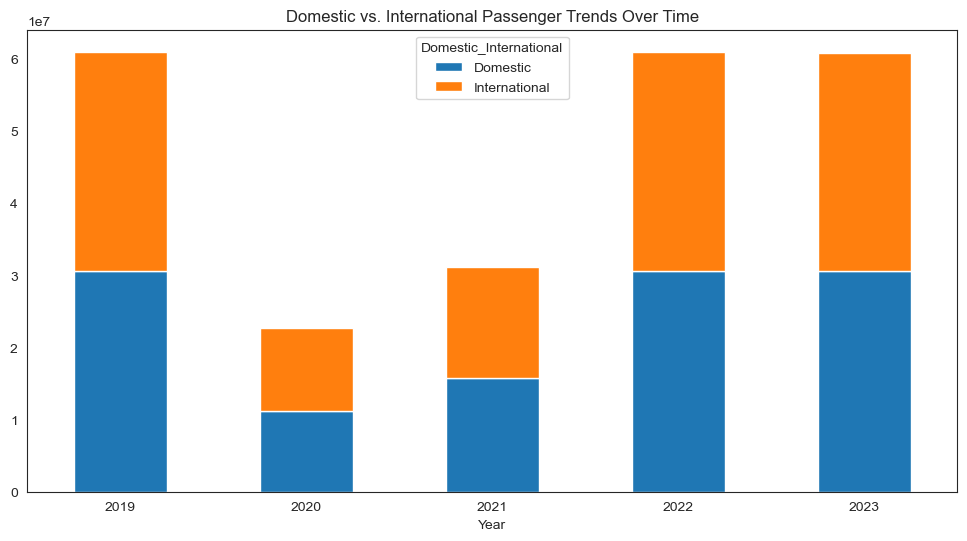

In [1919]:
# Domestic vs Internationa passenger trends over the years
LA.groupby(['Year', 'Domestic_International'])['Passenger_Count'].sum().unstack().plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Domestic vs. International Passenger Trends Over Time')
plt.xticks(rotation = 0)
plt.show()

The chart highlights the ups and downs in domestic and international passenger numbers over the years. There’s a sharp drop in 2020, likely due to the COVID-19 pandemic, followed by a steady recovery. It also shows that domestic passengers consistently outnumber international ones each year, making it easy to compare their proportions over time.

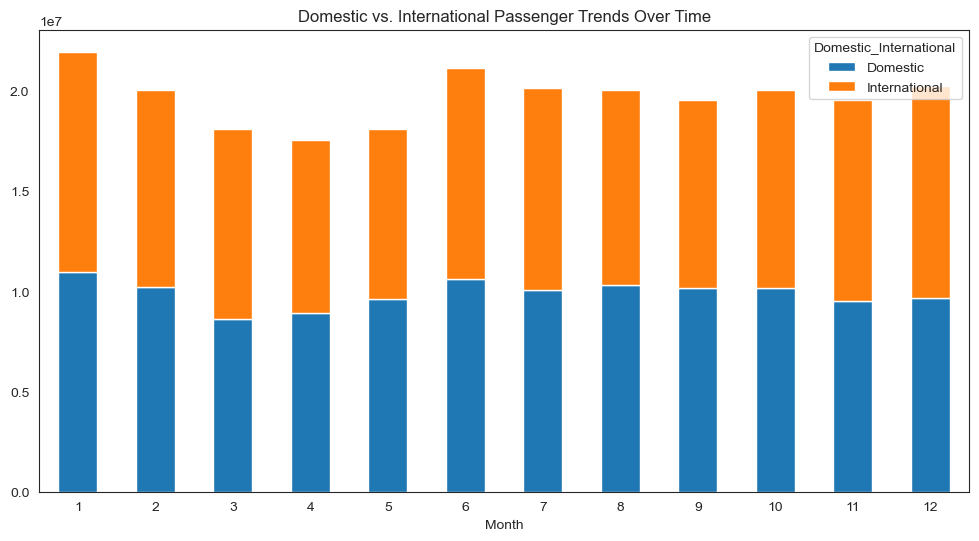

In [1921]:
# Domestic vs Internationa passenger trends over months
LA.groupby(['Month', 'Domestic_International'])['Passenger_Count'].sum().unstack().plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Domestic vs. International Passenger Trends Over Time')
plt.xticks(rotation = 0)
plt.show()

The chart shows how domestic and international passenger numbers change throughout the year, with clear seasonal trends. Domestic travel stays fairly steady, while international travel fluctuates more, peaking in June. It also highlights that domestic passengers consistently make up the majority, while international numbers vary but remain significant.

# Peak Hour Clasification

The passenger count will be classified into two classes; Peak and Off-Peak, using the 75th percentile as the threshold.

In [1925]:
# defining classes
threshold = LA['Passenger_Count'].quantile(0.75)
LA['Peak_Off_Peak'] = LA['Passenger_Count'].apply(lambda x: 'Peak' if x >= threshold else 'Off-Peak')

In [1578]:
LA.head()

,DataExtractDate,Terminal,Arrival_Departure,Domestic_International,Passenger_Count,Year,Month,Day,Weekday,Hour,Peak_Off_Peak
0,2019-01-01 20:15:30,TBIT,Arrival,International,27705,2019,1,1,1,20,Peak
1,2019-01-01 23:25:00,T5,Arrival,Domestic,19635,2019,1,1,1,23,Peak
2,2019-01-01 03:34:50,T2,Arrival,International,22498,2019,1,1,1,3,Peak
3,2019-01-01 15:15:35,T7,Arrival,International,18680,2019,1,1,1,15,Peak
4,2019-01-01 05:26:02,T4,Arrival,Domestic,20243,2019,1,1,1,5,Peak


In [1579]:
LAx = LA.copy() # making a copy of the dataset

# Preprocessing

In [1581]:
# encoding categorical columns
cat = LAx.select_dtypes('object')
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in cat:
    LAx[col] = le.fit_transform(LAx[col])

LAx.head()

,DataExtractDate,Terminal,Arrival_Departure,Domestic_International,Passenger_Count,Year,Month,Day,Weekday,Hour,Peak_Off_Peak
0,2019-01-01 20:15:30,9,0,1,27705,2019,1,1,1,20,1
1,2019-01-01 23:25:00,5,0,0,19635,2019,1,1,1,23,1
2,2019-01-01 03:34:50,2,0,1,22498,2019,1,1,1,3,1
3,2019-01-01 15:15:35,7,0,1,18680,2019,1,1,1,15,1
4,2019-01-01 05:26:02,4,0,0,20243,2019,1,1,1,5,1


In [1582]:
from sklearn.model_selection import train_test_split, GridSearchCV
y = LAx['Peak_Off_Peak']
X = LAx.drop(['Peak_Off_Peak', 'Passenger_Count', 'DataExtractDate'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=30, random_state=26)

In [1583]:
from xgboost import XGBClassifier
from collections import Counter


counter = Counter(y_train)
neg, pos = counter[0], counter[1]

# Compute scale_pos_weight
scale_pos_weight = neg / pos

xgb = XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight, random_state=26)

In [1584]:
cv_params = {'max_depth': [4,5,6,7,8], 
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [75, 100, 125]
             }    

scoring = {'accuracy', 'precision', 'recall', 'f1'}

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

In [1585]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 13min 4s
Wall time: 4min 51s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=26, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             refit='f1', scoring={'accuracy', 'precision', 'f1', 'recall'})

In [1586]:
y_pred = xgb_cv.predict(X_test) # model predictions

In [1587]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [1588]:
# metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Accuracy: {acc:.2f}')
print(f'Precision: {prec:.2f}')
print(f'Recall: {rec:.2f}')
print(f'F1: {f1:.2f}')

Accuracy: 0.97
Precision: 0.89
Recall: 1.00
F1: 0.94


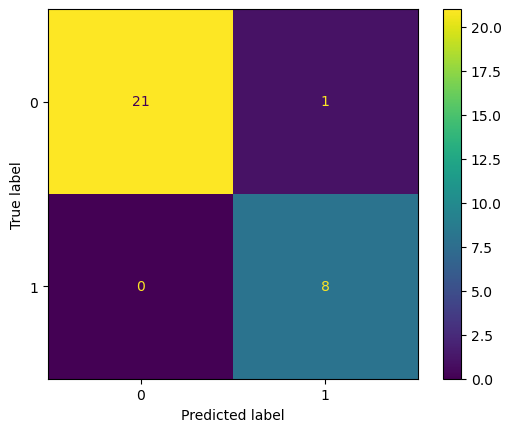

In [1589]:
cm = confusion_matrix(y_test,y_pred,labels = xgb_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = xgb_cv.classes_)
disp.plot()

## Precision vs Recall for Airport Peak Time Prediction  

When predicting the busiest times at an airport, recall should be the main focus.  

### Why Focus on Recall?  
- Missing a busy period (false negatives) could lead to staff shortages, delays, and overall chaos.  
- It’s safer to overestimate than to underestimate. If a time slot is wrongly flagged as busy, the airport might over-pdrepare, but that’s better than being caught off guard.  
- Even if some quieter times are mistakenly predicted as busy (false positives), the impact isn’t as bad as missing an actual peak time.  

### When Does Precision Matter More?  
- If the goal is to avoid unnecessary costs by only allocating extra staff when absolutely needed.  
- Too many false alarms (low precision) could lead to overstaffing and wasted resources.  

### Final Thought  
Since the main goal is to avoid missing peak times, recall should be the priority, even if it means sometimes o-preparing.  


# Segmentaton
Grouping terminals based on passenger flow pattern using K-Means Clustering

### Preprocessing
Rather than only looking at passneger count at each terminal, other feature will be engineered to give more 'characteristic' to each column, to help K-Means group/cluster the columns better than it would with just passenger count. Also, there is data each day for every terminal, therefore there are multiple unique dates in the dataset. This means dates and terminal have to be aggregated.

In [1683]:
LA.tail()

,DataExtractDate,Terminal,Arrival_Departure,Domestic_International,Passenger_Count,Year,Month,Day,Weekday,Hour,Peak_Off_Peak,Date,Formatted_Date
20081,2023-12-31 06:50:29,T6,Departure,Domestic,11192,2023,12,31,6,6,Off-Peak,2023-01-31,2023-01-31
20082,2023-12-31 16:42:43,T3,Departure,International,10825,2023,12,31,6,16,Off-Peak,2023-01-31,2023-01-31
20083,2023-12-31 12:47:18,TBIT West Gates,Arrival,International,6916,2023,12,31,6,12,Off-Peak,2023-01-31,2023-01-31
20084,2023-12-31 10:14:11,T8,Departure,Domestic,6153,2023,12,31,6,10,Off-Peak,2023-01-31,2023-01-31
20085,2023-12-31 08:52:26,Miscellaneous Terminal,Arrival,International,3685,2023,12,31,6,8,Off-Peak,2023-01-31,2023-01-31


In [1689]:
# aggregating terminals and date
aggregated_LA = LA.groupby(['Date', 'Terminal']).agg(
    Passenger_Count=('Passenger_Count', 'sum'),
    Arrivals=('Arrival_Departure', lambda x: (x == 'Arrival').sum()),
    Departures=('Arrival_Departure', lambda x: (x == 'Departure').sum()),
    Domestic=('Domestic_International', lambda x: (x == 'Domestic').sum()),
    International=('Domestic_International', lambda x: (x == 'International').sum())
).reset_index()

# creating a dataframe of the features
terminal_features_df = pd.DataFrame(aggregated_LA)
terminal_features_df

,Date,Terminal,Passenger_Count,Arrivals,Departures,Domestic,International
0,2019-01-01,Miscellaneous Terminal,47453,9,3,6,6
1,2019-01-01,T1,207209,8,4,7,5
2,2019-01-01,T2,265526,7,5,1,11
3,2019-01-01,T3,119865,4,8,6,6
4,2019-01-01,T4,209135,9,3,7,5
...,...,...,...,...,...,...,...
1700,2023-01-31,T6,93988,3,4,5,2
1701,2023-01-31,T7,128139,5,2,3,4
1702,2023-01-31,T8,42845,1,6,5,2
1703,2023-01-31,TBIT,224614,4,3,3,4


In [1693]:
# computing arrival and depature ratios
aggregated_LA['Arrival_Ratio'] = aggregated_LA['Arrivals'] / (aggregated_LA['Arrivals'] + aggregated_LA['Departures'])
aggregated_LA['Domestic_Ratio'] = aggregated_LA['Domestic'] / (aggregated_LA['Domestic'] + aggregated_LA['International'])

terminal_features_df = pd.DataFrame(aggregated_LA)
terminal_features_df

,Date,Terminal,Passenger_Count,Arrivals,Departures,Domestic,International,Arrival_Ratio,Domestic_Ratio
0,2019-01-01,Miscellaneous Terminal,47453,9,3,6,6,0.750000,0.500000
1,2019-01-01,T1,207209,8,4,7,5,0.666667,0.583333
2,2019-01-01,T2,265526,7,5,1,11,0.583333,0.083333
3,2019-01-01,T3,119865,4,8,6,6,0.333333,0.500000
4,2019-01-01,T4,209135,9,3,7,5,0.750000,0.583333
...,...,...,...,...,...,...,...,...,...
1700,2023-01-31,T6,93988,3,4,5,2,0.428571,0.714286
1701,2023-01-31,T7,128139,5,2,3,4,0.714286,0.428571
1702,2023-01-31,T8,42845,1,6,5,2,0.142857,0.714286
1703,2023-01-31,TBIT,224614,4,3,3,4,0.571429,0.428571


In [1697]:
# Feature Engineering from Time Series 
terminal_features = aggregated_LA.groupby('Terminal').agg(
    Avg_Passenger_Count=('Passenger_Count', 'mean'),
    Avg_Arrival_Ratio=('Arrival_Ratio', 'mean'),
    Avg_Domestic_Ratio=('Domestic_Ratio', 'mean'),
    Std_Passenger_Count=('Passenger_Count', 'std')
).reset_index()

km_df = pd.DataFrame(terminal_features)
km_df

,Terminal,Avg_Passenger_Count,Avg_Arrival_Ratio,Avg_Domestic_Ratio,Std_Passenger_Count
0,Miscellaneous Terminal,36536.606452,0.491733,0.505963,13429.465630
1,T1,154581.335484,0.501012,0.492522,57111.418753
2,T2,191494.458065,0.513078,0.505258,71011.240056
3,T3,92865.748387,0.484164,0.489324,34170.653204
4,T4,161271.154839,0.500901,0.482370,59840.199361
5,T5,199035.993548,0.477454,0.502953,72998.533948
6,T6,125835.077419,0.497270,0.500524,45828.959873
7,T7,170632.051613,0.508616,0.512945,63242.491062
8,T8,58046.341935,0.502569,0.495064,21300.567841
9,TBIT,272523.503226,0.488696,0.501920,101271.572082


In [1707]:
# engineering arrival and departure ratios into a single colunm
km_df['Net_Arrival_Ratio'] = 2 * km_df['Avg_Arrival_Ratio'] - 1
km_df.drop(['Avg_Arrival_Ratio', 'Avg_Domestic_Ratio'], axis = 1, inplace = True)
km_df

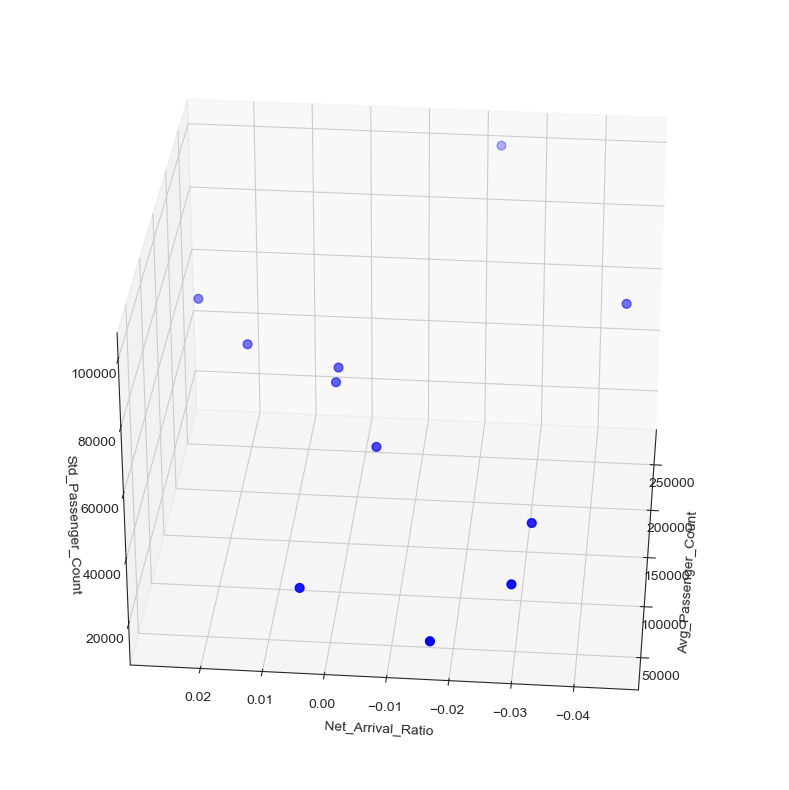

In [1745]:
from mpl_toolkits.mplot3d import Axes3D

sns.set_style('white')
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(km_df['Avg_Passenger_Count'], km_df['Net_Arrival_Ratio'],km_df['Std_Passenger_Count'], c='blue', s=40)
ax.view_init(30, 185)
ax.set(xlabel='Avg_Passenger_Count', ylabel='Net_Arrival_Ratio', zlabel='Std_Passenger_Count')
plt.show()

In [1715]:
from sklearn.preprocessing import StandardScaler
X = km_df.drop('Terminal', axis = 1)
ss = StandardScaler()
X_scaled = ss.fit_transform(X) 

In [1719]:
from sklearn.cluster import KMeans

num_clusters = [i for i in range(2, 6)]
def kmeans_inertia(num_clusters, X):
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=5826)
        kms.fit(X)
        inertia.append(kms.inertia_)
    return inertia

inertia = kmeans_inertia(num_clusters, X)
inertia

[16048403395.646889, 5851973947.604665, 2756576251.9886594, 1270467776.7207296]

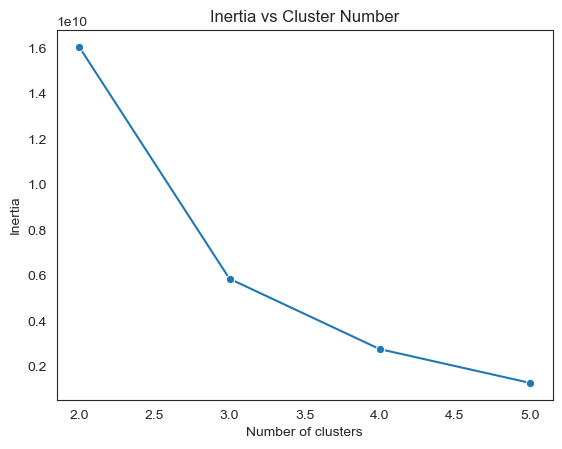

In [1721]:
# Line plot to show relationship between cluster number and inertia
sns.lineplot(x=num_clusters, y=inertia, marker = 'o')
plt.xlabel('Number of clusters');
plt.ylabel('Inertia');
plt.title('Inertia vs Cluster Number');

In [1723]:
from sklearn.metrics import silhouette_score
# Writing a function taht returns a list of each k-value's score.
def kmeans_sil(num_clusters, X):
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=5826)
        kms.fit(X)
        sil_score.append(silhouette_score(X, kms.labels_))

    return sil_score


sil_score = kmeans_sil(num_clusters, X_scaled)
sil_score

[0.37929440332012915,
 0.4960775414233105,
 0.4343476364948232,
 0.4245665314315221]

Text(0.5, 1.0, 'Silhouette Score vs Number of CLusters')

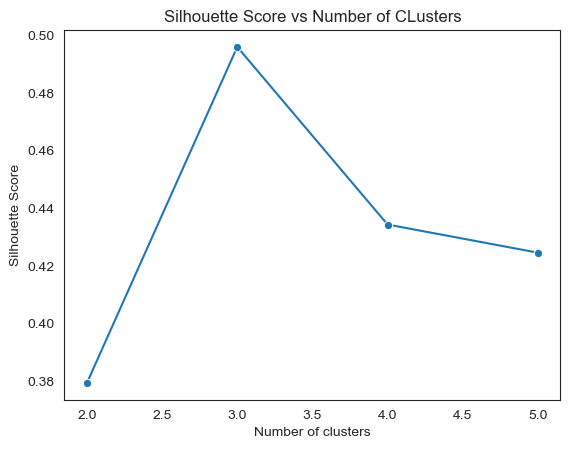

In [1725]:
# Line plot to show relationship between cluster number and silhouette score
sns.lineplot(x=num_clusters, y=sil_score, marker = 'o')
plt.xlabel('Number of clusters');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score vs Number of CLusters')

In [1733]:
# fit a three-cluster model to the dataset

kmeans3 = KMeans(n_clusters=3,random_state=26)
kmeans3.fit(X_scaled)
# unique labels of the model
print('Unique labels:', np.unique(kmeans3.labels_))

Unique labels: [0 1 2]


In [1735]:
km_df['cluster'] = kmeans3.labels_
km_df.head()

,Terminal,Avg_Passenger_Count,Std_Passenger_Count,Net_Arrival_Ratio,cluster
0,Miscellaneous Terminal,36536.606452,13429.465630,-0.016534,2
1,T1,154581.335484,57111.418753,0.002025,1
2,T2,191494.458065,71011.240056,0.026156,1
3,T3,92865.748387,34170.653204,-0.031672,2
4,T4,161271.154839,59840.199361,0.001801,1


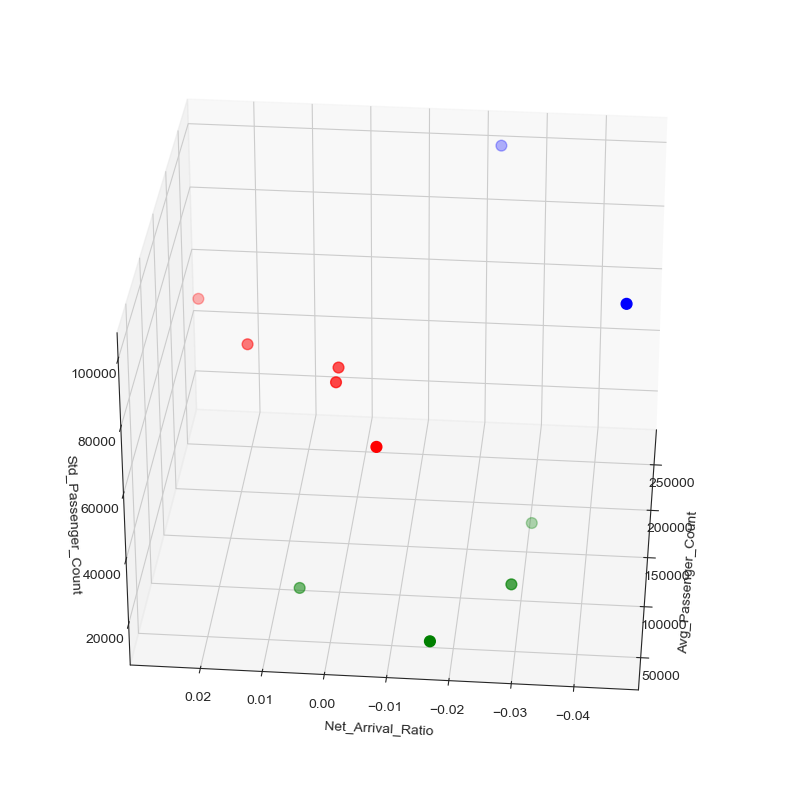

In [1747]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(km_df.iloc[:, 1:])

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(km_df.Avg_Passenger_Count[km_df.cluster == 0], km_df['Net_Arrival_Ratio'][km_df.cluster == 0], 
           km_df['Std_Passenger_Count'][km_df.cluster == 0], c='blue', s=60)
ax.scatter(km_df.Avg_Passenger_Count[km_df.cluster == 1], km_df['Net_Arrival_Ratio'][km_df.cluster == 1], 
           km_df['Std_Passenger_Count'][km_df.cluster == 1], c='red', s=60)
ax.scatter(km_df.Avg_Passenger_Count[km_df.cluster == 2], km_df['Net_Arrival_Ratio'][km_df.cluster == 2], 
           km_df['Std_Passenger_Count'][km_df.cluster == 2], c='green', s=60)

ax.view_init(30, 185)
ax.set(xlabel='Avg_Passenger_Count', ylabel='Net_Arrival_Ratio', zlabel='Std_Passenger_Count')

plt.show()

In [1753]:
# to see which terminals belong to each cluster
clustered_terminals = km_df.groupby('cluster')['Terminal'].apply(list)
print(clustered_terminals)

cluster
0                                           [T5, TBIT]
1                                 [T1, T2, T4, T6, T7]
2    [Miscellaneous Terminal, T3, T8, TBIT West Gates]
Name: Terminal, dtype: object


### Cluster Interpretation  

**Cluster 0 (Blue): [T5, TBIT]**  
These terminals have high passenger traffic with significant fluctuations. T5 and TBIT are likely the busiest, handling large crowds. A negative net arrival ratio suggests they see more departures than arrivals.  

**Cluster 1 (Red): [T1, T2, T4, T6, T7]**  
Passenger traffic here is moderate and steady, with balanced arrivals and departures. These terminals handle a consistent flow without the extreme ups and downs seen in Cluster 0.  

**Cluster 2 (Green): [Miscellaneous Terminal, T3, T8, TBIT West Gates]**  
These terminals experience lower passenger traffic with minimal fluctuations. They are likely smaller or serve specific purposes, maintaining a stable flow. Like Cluster 0, they also see more departures than arrivals.  

### Key Takeaways  

- Traffic and terminal size: TBIT and T5 likely serve the most passengers, while Cluster 2 terminals are smaller or have niche roles.  
- Operational planning: Cluster 0 terminals may need flexible staffing to handle fluctuating demand.  
- Resource allocation: High-traffic terminals need more resources for check-in, security, and baggage, while smaller terminals may benefit from streamlined operations.  
- Arrival and departure management: Terminals with more departures should prioritise departure processes fhis works for you!

# Passenger Forecasting

### Preprocessing
`DataExtractDate` has timestamps and multiple entries for the same date. Months have been extracted from it previously, therefore i will aggregate passenger counts for each month and a monthly passenger count forecast will be carried out.

In [1762]:
LA.head()

,DataExtractDate,Terminal,Arrival_Departure,Domestic_International,Passenger_Count,Year,Month,Day,Weekday,Hour,Peak_Off_Peak,Date,Formatted_Date
0,2019-01-01 20:15:30,TBIT,Arrival,International,27705,2019,1,1,1,20,Peak,2019-01-01,2019-01-01
1,2019-01-01 23:25:00,T5,Arrival,Domestic,19635,2019,1,1,1,23,Peak,2019-01-01,2019-01-01
2,2019-01-01 03:34:50,T2,Arrival,International,22498,2019,1,1,1,3,Peak,2019-01-01,2019-01-01
3,2019-01-01 15:15:35,T7,Arrival,International,18680,2019,1,1,1,15,Peak,2019-01-01,2019-01-01
4,2019-01-01 05:26:02,T4,Arrival,Domestic,20243,2019,1,1,1,5,Peak,2019-01-01,2019-01-01


In [1951]:
# aggregate Passenger_Count by Month and Year
LLA = LA.groupby(['Year', 'Month'])['Passenger_Count'].sum().reset_index()

# create a single 'ds' column representing Year-Month
LLA['ds'] = pd.to_datetime(LLA['Year'].astype(str) + '-' + LLA['Month'].astype(str) + '-01')

# rename Passenger_Count to 'y'
LLA.rename(columns={'Passenger_Count': 'y'}, inplace=True)

In [ ]:
LLA.head()

In [1983]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
LLA['y'] = scaler.fit_transform(LLA[['y']])

In [1955]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# Train-Test Split (e.g., last 12 months as validation)
train = LLA[:-12]  # Training set
test = LLA[-12:]  # Validation set

In [1989]:
from prophet import Prophet

model = Prophet()
model.fit(train)

future = model.make_future_dataframe(periods=len(test), freq='MS')
forecast = model.predict(future)

21:55:56 - cmdstanpy - INFO - Chain [1] start processing
21:55:56 - cmdstanpy - INFO - Chain [1] done processing


In [1991]:
# prredictions for the Validation Period
predictions = forecast['yhat'][-len(test):]

#  Metrics
mae = mean_absolute_error(test['y'], predictions)
rmse = np.sqrt(mean_squared_error(test['y'], predictions))
mape = mean_absolute_percentage_error(test['y'], predictions)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MAE: 1225277.5326365568
RMSE: 1254410.4672424563
MAPE: 0.24106729547502107


In [1993]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,3.356729e+06,2.168353e+06,6.335577e+06,3.356729e+06,3.356729e+06,761884.363606,761884.363606,761884.363606,761884.363606,761884.363606,761884.363606,0.0,0.0,0.0,4.118613e+06
1,2019-02-01,3.361874e+06,1.421779e+06,5.748868e+06,3.361874e+06,3.361874e+06,252374.586285,252374.586285,252374.586285,252374.586285,252374.586285,252374.586285,0.0,0.0,0.0,3.614249e+06
2,2019-03-01,3.366521e+06,1.209643e+06,5.434082e+06,3.366521e+06,3.366521e+06,-78031.440647,-78031.440647,-78031.440647,-78031.440647,-78031.440647,-78031.440647,0.0,0.0,0.0,3.288490e+06
3,2019-04-01,3.371666e+06,1.106476e+06,5.391881e+06,3.371666e+06,3.371666e+06,-128030.811274,-128030.811274,-128030.811274,-128030.811274,-128030.811274,-128030.811274,0.0,0.0,0.0,3.243636e+06
4,2019-05-01,3.376645e+06,1.245073e+06,5.467324e+06,3.376645e+06,3.376645e+06,22664.080936,22664.080936,22664.080936,22664.080936,22664.080936,22664.080936,0.0,0.0,0.0,3.399310e+06


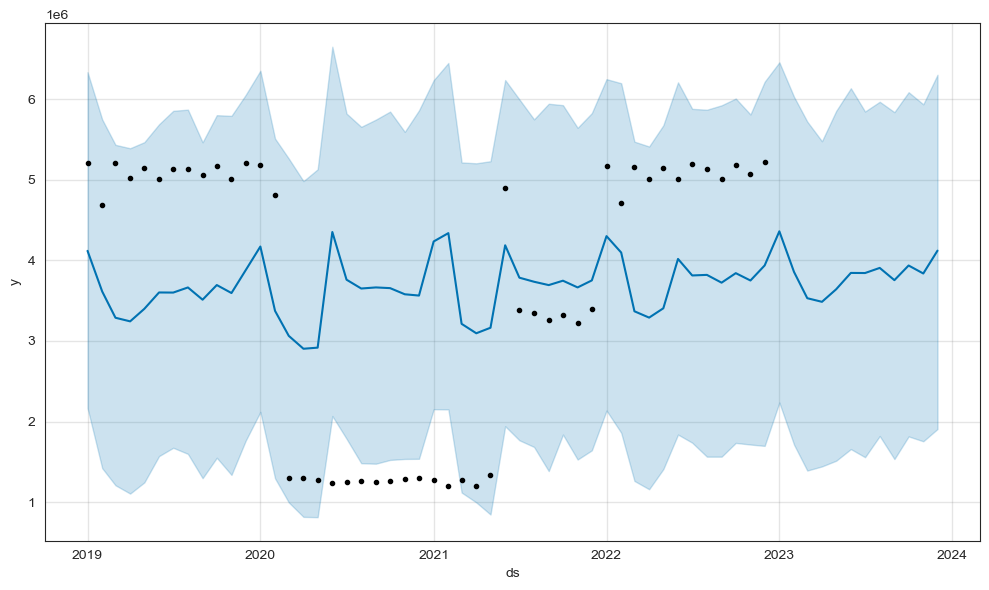

In [1995]:
model.plot(forecast)
plt.show()

### Past Trends (2019 - 2023)  
Looking at the actual passenger numbers (black dots), there are two clear traffic levels—one around 5 million and another much lower at 1.2 million. This suggests a sharp shift in passenger volume at certain points.  

There’s a noticeable dip around 2020/2021, likely due to a major real-world event (most likely the COVID-19 pandemic). After this drop, the data shows a recovery trend, though not necessarily returning to pre-pandemic levels.  

### Forecast (2023 - 2024)  
The model’s prediction (blue line) suggests a stable yet fluctuating pattern in passenger numbers moving forward. However, the light blue shaded area represents uncertainty—indicating that future passenger counts could vary widely. This uncertainty comes from the inconsistent nature of past data, making precise forecasting more difficult.  

### Key Takeaways  
- Passenger traffic saw a major disruption around 2020/2021, likely linked to the pandemic.  
- The forecast points to a recovery, but fluctuations will continue.  
- The two distinct traffic levels suggest either a shift in operations or a change in data collection methods.  
- Predicting future trends with high precision is tough due to the unpredictable changes in past data.  

In short, passenger numbers have been through big shifts, and while things are stabilising, there’s still a lot of uncertainty in what comes next.

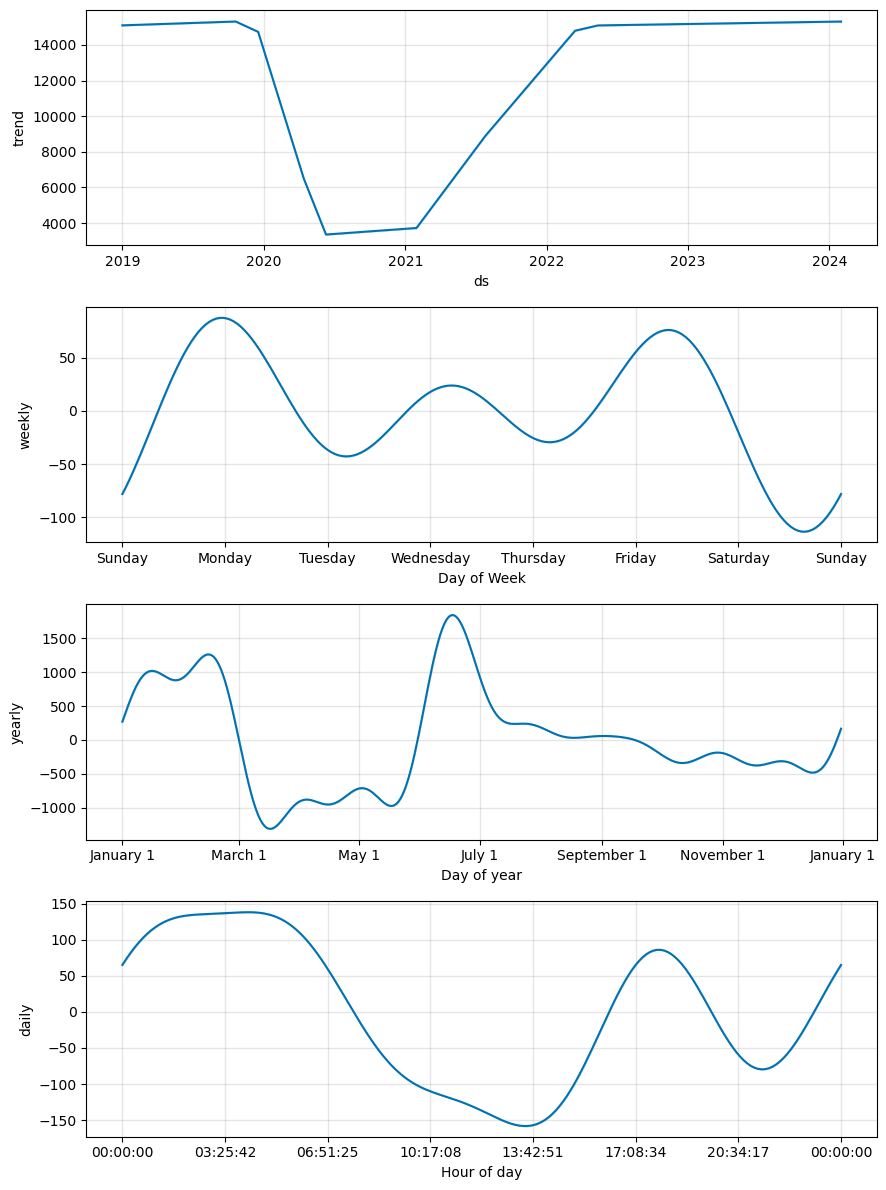

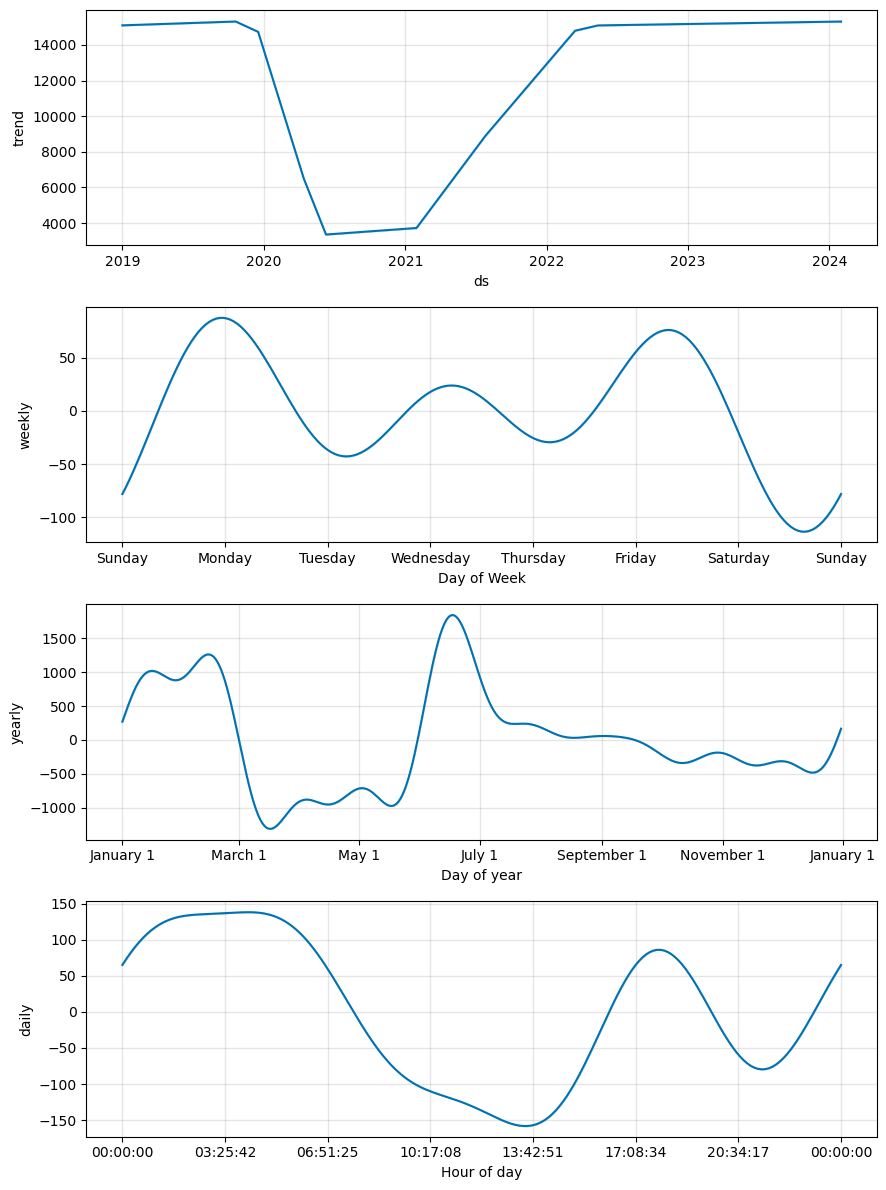

In [1595]:
model.plot_components(forecast)